In [3]:
#!/usr/bin/env python3
# ---------------------------------------  KernelSHAP convergence dashboard
import numpy as np, torch, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader, Subset
from my_load import CPU_Unpickler
from numpy.random import default_rng
import matplotlib.gridspec as gridspec
import pickle

# Human-friendly aliases for supervoxel types
ALIAS_MAP = {
    "full-organs": "Full organs",
    "FCC": "Regular",
    "FCC-organs": "Hybrid",
}

# ------------------------------ 2. HELPERS --------------------------------
def active_fraction(abs_coefs: np.ndarray, frac: float = 0.95) -> int:
    """
    Return the minimal number of features whose |φ_i| sum to `frac`
    (e.g. 0.95) of the total attribution magnitude, over the total number of features.

    If all |φ| sum to 0, returns 0.
    """
    total = abs_coefs.sum()
    if total == 0:  # all coefficients are zero 
        return 0
    sorted_abs = np.sort(abs_coefs)[::-1]
    cum = np.cumsum(sorted_abs)
    active_features = int((cum < frac * total).sum() + 1)   # +1 for the first >=
    return active_features / len(abs_coefs)

def calculate_r2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calculate R² score with proper error handling.
    
    Returns 0.0 if total sum of squares is zero (constant target).
    """
    ss_res = float(((y_true - y_pred) ** 2).sum())
    ss_tot = float(((y_true - y_true.mean()) ** 2).sum())
    return 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0

def calculate_jump(beta: torch.Tensor, beta_prev: torch.Tensor, ord: int) -> float:
    """
    Calculate the jump (L1 norm) between two coefficient vectors.
    """
    eps = 1e-10
    difference = float(torch.norm(beta - beta_prev, p=ord))
    normalization = float(torch.norm(beta_prev, p=ord))

    return difference / (normalization + eps)

def compute_metrics(supervoxel_type: str, aggregation_type: str):
    """
    Compute convergence metrics for a given supervoxel type and aggregation type.
    Saves results to pickle files for later use.
    """
    ROOT_DIR = Path(f"../output/{supervoxel_type}/{aggregation_type}")
    DATASET_LENGTH = 1000 if supervoxel_type == "full-organs" else 2000
    PATIENT_IDS = ["00004", "00005", "00024", "00027", "00029", "00034", "00039", "00044"]
    VAL_ROWS = 40
    STEP_SIZE = 5
    CHECKPOINTS = np.arange(STEP_SIZE, DATASET_LENGTH + 1 - VAL_ROWS, STEP_SIZE)
    RNG = default_rng(0)
    FRAC_TARGET = 0.8

    conv_L1, delta, val_mae, val_r2, nz_feat, cond_num = (
        [] for _ in range(6)
    )

    for pid in PATIENT_IDS:
        pkl_path = ROOT_DIR / pid / "dataset.pkl"
        with open(pkl_path, "rb") as f:
            ds = CPU_Unpickler(f).load()
        if isinstance(ds, DataLoader):
            ds = ds.dataset
        X, y, w = (t.cpu() for t in ds.tensors)
        D = X.shape[1]
        f_x = y[0].item()

        idx_all = np.arange(X.shape[0])
        idx_choose_validation = idx_all[2:]
        val_idx = RNG.choice(idx_choose_validation, size=VAL_ROWS, replace=False)
        train_idx = np.setdiff1d(idx_all, val_idx, assume_unique=True)

        X_val, y_val = X[val_idx].numpy(), y[val_idx].numpy()

        beta_prev = None
        cv, dl, mae, r2, cn = [], [], [], [], []

        coefs_list = []
        for n in CHECKPOINTS:
            n_train = min(n, len(train_idx))
            idx_sub = train_idx[:n_train]
            X_b, y_b, w_b = X[idx_sub].numpy(), y[idx_sub].numpy(), w[idx_sub].numpy()
            reg = LinearRegression()
            reg.fit(X_b, y_b, sample_weight=w_b)

            beta = torch.as_tensor(np.concatenate([[reg.intercept_], reg.coef_]),
                                   dtype=torch.float32)

            coefs_list.append(reg.coef_)

            if beta_prev is not None:
                cv.append(calculate_jump(beta, beta_prev, ord=1))
            beta_prev = beta.clone()

            dl.append(abs(f_x - beta.sum().item()))

            y_pred_val = reg.intercept_ + X_val @ reg.coef_
            mae.append(float(np.abs(y_val - y_pred_val).mean()))

            r2_val = calculate_r2(y_val, y_pred_val)
            r2.append(r2_val)

            Wsqrt = np.sqrt(w_b).reshape(-1, 1)
            Xw = np.column_stack([np.ones(n_train), X_b]) * Wsqrt
            try:
                U, svals, _ = np.linalg.svd(Xw, full_matrices=False)
                cn.append(svals[0] / svals[-1])
            except np.linalg.LinAlgError:
                cn.append(np.inf)

        nnz = [active_fraction(np.abs(c), FRAC_TARGET) for c in coefs_list]

        conv_L1.append(cv)
        delta.append(dl)
        val_mae.append(mae)
        val_r2.append(r2)
        nz_feat.append(nnz)
        cond_num.append(cn)

    to_stats = lambda lst: (np.mean(lst, axis=0), np.std(lst, axis=0))
    conv_m, conv_s = to_stats(conv_L1)
    delta_m, delta_s = to_stats(delta)
    mae_m, mae_s = to_stats(val_mae)
    r2_m, r2_s = to_stats(val_r2)
    nz_m, nz_s = to_stats(nz_feat)
    cond_m, cond_s = to_stats(cond_num)

    def smooth(arr: np.ndarray, win: int = 100 // STEP_SIZE) -> np.ndarray:
        pad = win // 2
        sm = np.empty_like(arr)
        for i in range(len(arr)):
            lo, hi = max(0, i - pad), min(len(arr), i + pad + 1)
            sm[i] = arr[lo:hi].mean()
        return sm

    for arr in (conv_m, delta_m, mae_m, nz_m):
        arr[:] = smooth(arr, win=5)

    x_conv = CHECKPOINTS[1:]

    # Save metrics to file
    metrics_data = {
        'x_conv': x_conv,
        'conv_m': conv_m, 'conv_s': conv_s,
        'delta_m': delta_m, 'delta_s': delta_s,
        'mae_m': mae_m, 'mae_s': mae_s,
        'r2_m': r2_m, 'r2_s': r2_s,
        'nz_m': nz_m, 'nz_s': nz_s,
        'cond_m': cond_m, 'cond_s': cond_s,
        'VAL_ROWS': VAL_ROWS,
        'FRAC_TARGET': FRAC_TARGET
    }
    
    # Create metrics directory if it doesn't exist
    metrics_dir = Path("metrics_data")
    metrics_dir.mkdir(exist_ok=True)
    
    # Save to file
    filename = metrics_dir / f"metrics_{supervoxel_type}_{aggregation_type}.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(metrics_data, f)
    
    print(f"Computed and saved metrics for {supervoxel_type} {aggregation_type}")

def load_metrics(supervoxel_type: str, aggregation_type: str):
    """Load precomputed metrics from file."""
    metrics_dir = Path("metrics_data")
    filename = metrics_dir / f"metrics_{supervoxel_type}_{aggregation_type}.pkl"
    
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Metrics file not found: {filename}")
        print("Run the compute_metrics function first.")
        return None

def plot_comparison_dashboard(aggregation_type: str):
    """
    Create comparison plots showing all supervoxel types together.
    """
    supervoxel_types = ["full-organs", "FCC", "FCC-organs"]
    colors = ['tab:blue', 'tab:red', 'tab:green']
    
    # Load metrics for all supervoxel types
    all_metrics = {}
    for sv_type in supervoxel_types:
        metrics = load_metrics(sv_type, aggregation_type)
        if metrics is None:
            return
        all_metrics[sv_type] = metrics
    
    # Create figure
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(3, 2, hspace=0.35, wspace=0.25)
    axes = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(2)]
    
    def shaded(ax, x, y, s, label, color):
        ax.plot(x, y, label=label, color=color)
        ax.fill_between(x, y - s, y + s, alpha=0.25, color=color)
    
    # Plot each metric for all supervoxel types
    for i, (sv_type, color) in enumerate(zip(supervoxel_types, colors)):
        metrics = all_metrics[sv_type]
        x_conv = metrics['x_conv']
        human_label = ALIAS_MAP.get(sv_type, sv_type)
        
        # Jump
        shaded(axes[0], x_conv, metrics['conv_m'], metrics['conv_s'], 
               label=human_label, color=color)
        
        # Delta SHAP
        shaded(axes[1], x_conv, metrics['delta_m'][1:], metrics['delta_s'][1:], 
               label=human_label, color=color)
        
        # Validation MAE
        shaded(axes[2], x_conv, metrics['mae_m'][1:], metrics['mae_s'][1:], 
               label=human_label, color=color)
        
        # Validation R2
        shaded(axes[3], x_conv, metrics['r2_m'][1:], metrics['r2_s'][1:], 
               label=human_label, color=color)
        
        # Condition number
        shaded(axes[4], x_conv, metrics['cond_m'][1:], metrics['cond_s'][1:], 
               label=human_label, color=color)
        
        # Active features
        shaded(axes[5], x_conv, metrics['nz_m'][1:], metrics['nz_s'][1:], 
               label=human_label, color=color)
    
    # Configure axes
    axes[0].set_yscale('log')
    axes[0].set_title('Jump')
    axes[0].grid(ls=':')
    axes[0].legend()
    
    axes[1].set_yscale('log')
    axes[1].set_title('Δ_SHAP completeness residual')
    axes[1].grid(ls=':')
    axes[1].legend()
    
    axes[2].set_yscale('log')
    axes[2].set_title('Validation MAE (40 masks)')
    axes[2].grid(ls=':')
    axes[2].legend()
    
    VAL_ROWS = all_metrics[supervoxel_types[0]]['VAL_ROWS']
    axes[3].set_title(f'Validation $R^2$ ({VAL_ROWS} masks)')
    axes[3].grid(ls=':')
    axes[3].legend()
    
    axes[4].set_yscale('log')
    axes[4].set_title('Condition number  $X_w$')
    axes[4].grid(ls=':')
    axes[4].legend()
    
    FRAC_TARGET = all_metrics[supervoxel_types[0]]['FRAC_TARGET']
    axes[5].set_title(f'Fraction of active features (≥ {FRAC_TARGET * 100:.0f}% mass)')
    axes[5].grid(ls=':')
    axes[5].legend()
    
    for ax in axes:
        ax.set_xlabel('samples')
    
    fig.suptitle(f'Convergence Comparison: {aggregation_type}', fontsize=16)
    fig.tight_layout()
    
    output_file = f"convergence_comparison_{aggregation_type}.png"
    fig.savefig(f"dashboards/{output_file}", dpi=300, bbox_inches='tight')
    print(f"Saved comparison plot → {output_file}")

In [6]:
# Compute metrics for all combinations and save to files
supervoxel_types = ["full-organs", "FCC", "FCC-organs"]
aggregation_types = ["true_positive", "false_positive", "dice", "logit_difference"]
#aggregation_types = ["false_positive", "dice", "logit_difference"]

print("Computing metrics for all combinations...")
for sv_type in supervoxel_types:
    for agg_type in aggregation_types:
        compute_metrics(sv_type, f"{agg_type}_aggregation")

Computing metrics for all combinations...
Computed and saved metrics for full-organs true_positive_aggregation
Computed and saved metrics for FCC true_positive_aggregation
Computed and saved metrics for FCC-organs true_positive_aggregation


Creating comparison plots...


/var/folders/7p/yjn93vy92vs94f3hdj934z3w0000gn/T/ipykernel_45683/1600326128.py:282: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved comparison plot → convergence_comparison_true_positive_aggregation.png
Saved comparison plot → convergence_comparison_false_positive_aggregation.png
Saved comparison plot → convergence_comparison_dice_aggregation.png
Saved comparison plot → convergence_comparison_logit_difference_aggregation.png


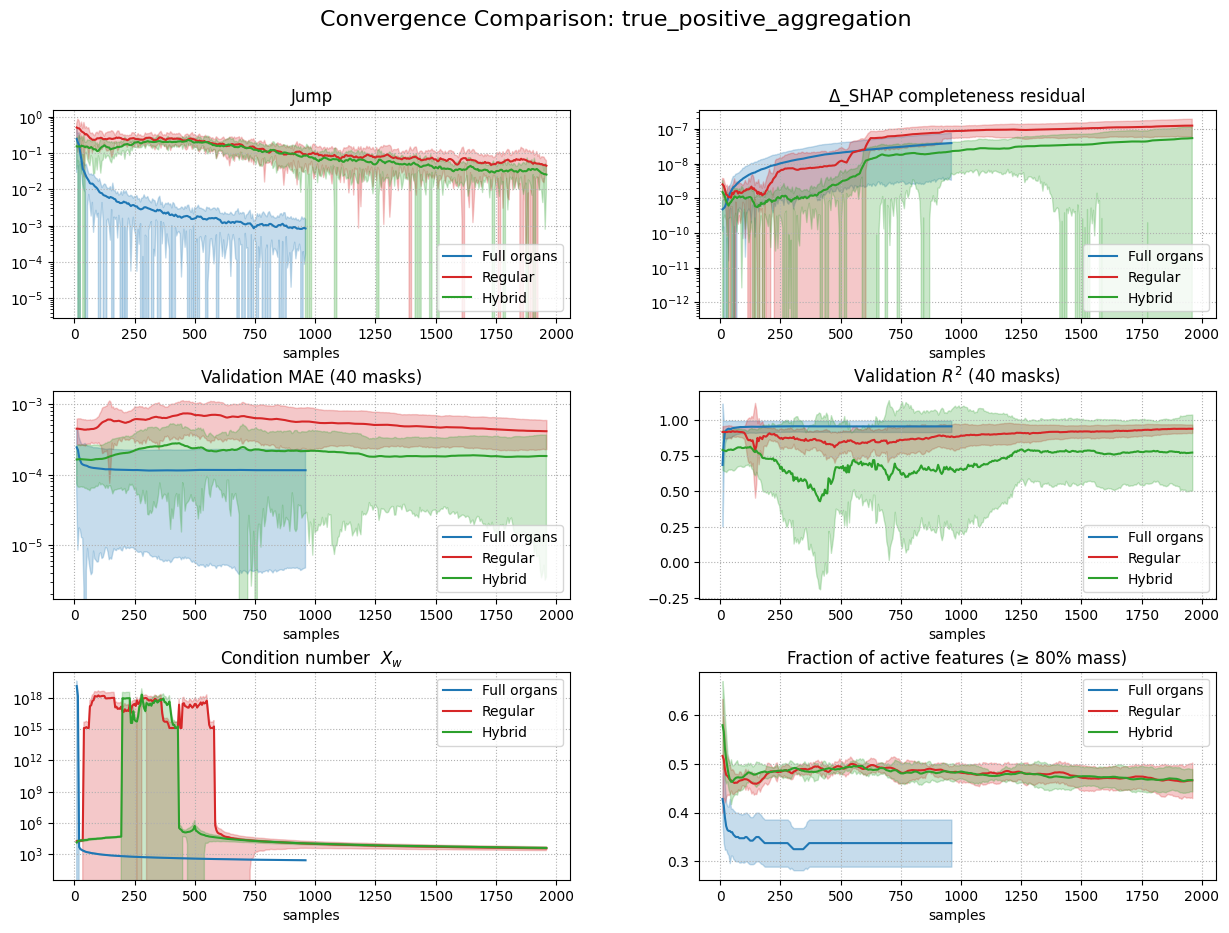

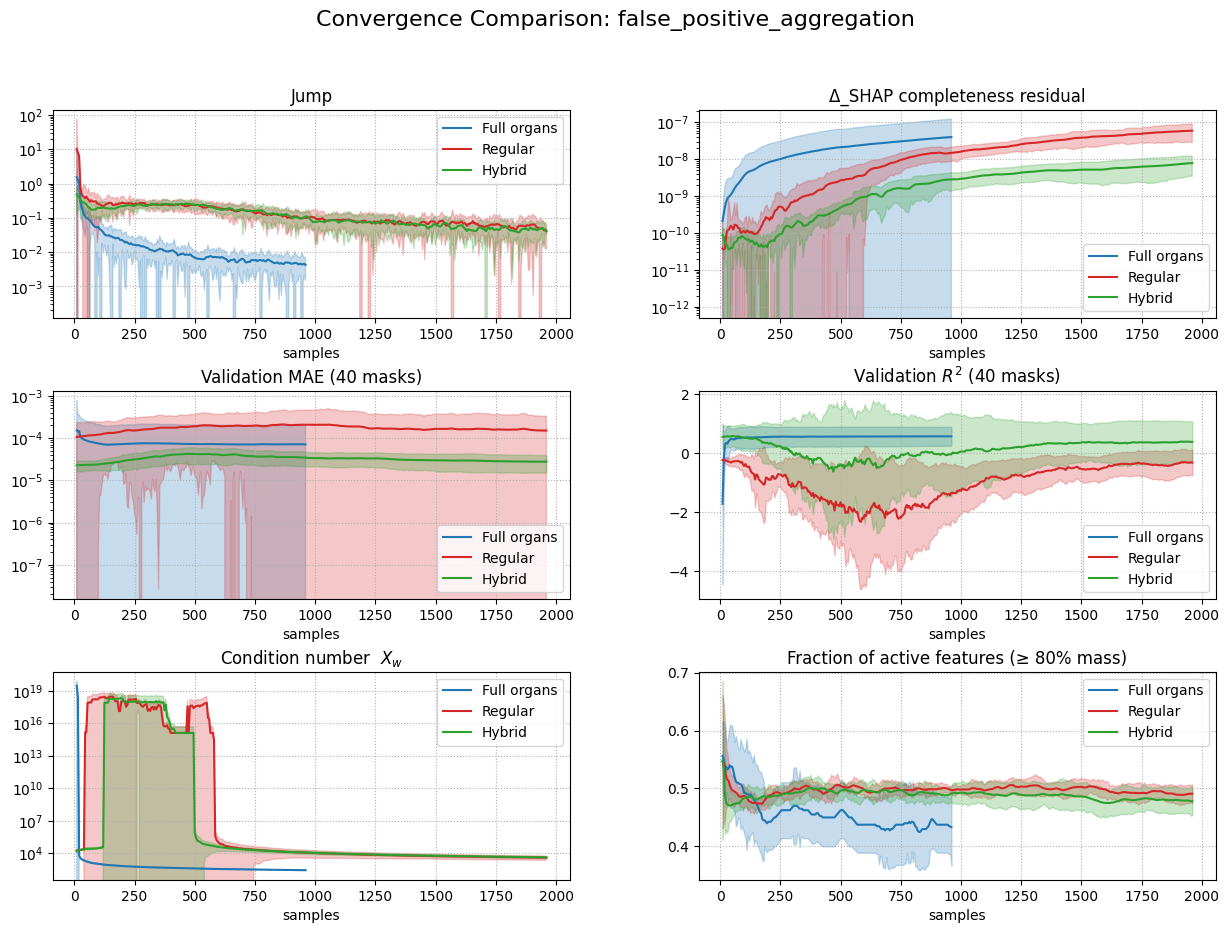

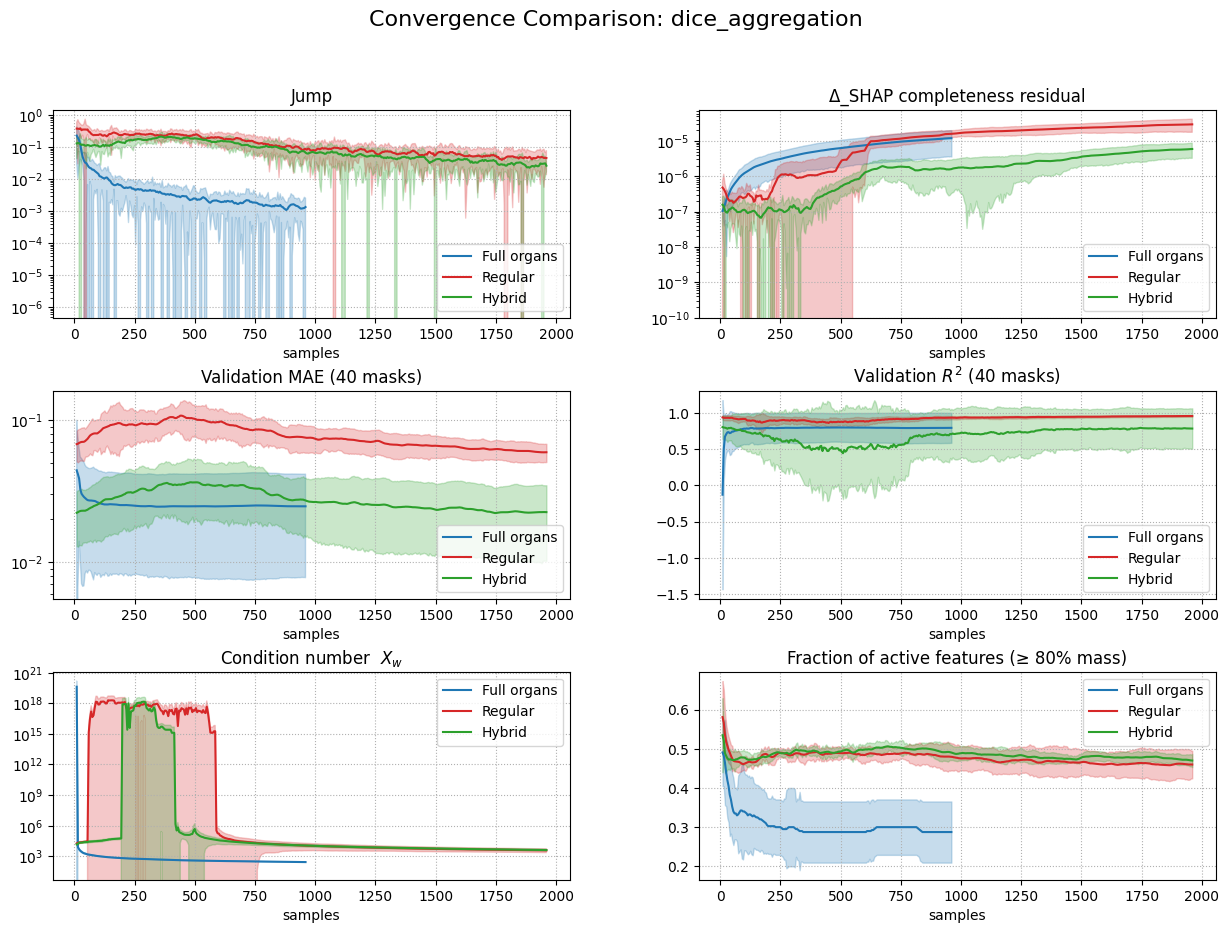

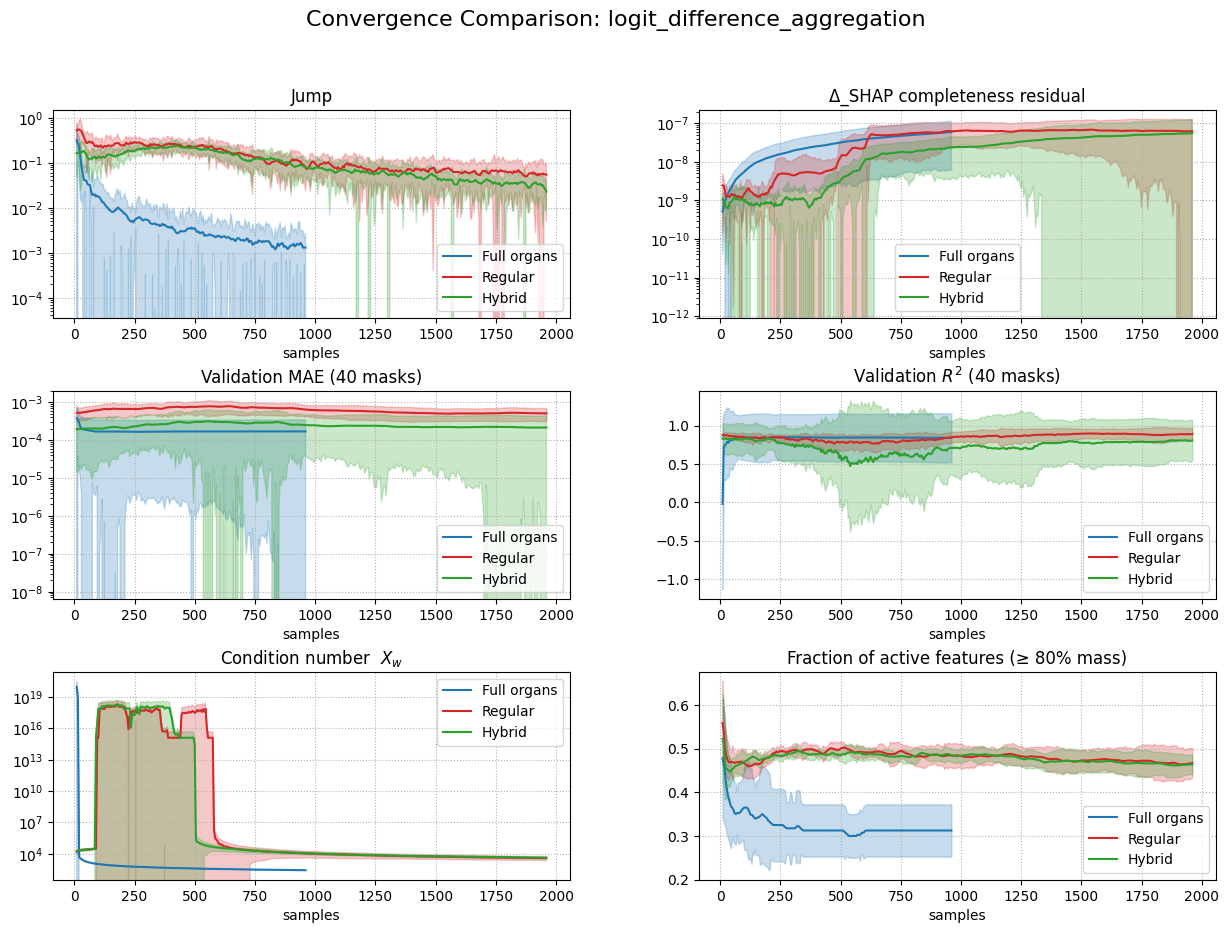

In [7]:
# Create comparison plots for each aggregation type
aggregation_types = ["true_positive", "false_positive", "dice", "logit_difference"]

print("Creating comparison plots...")
for agg_type in aggregation_types:
    plot_comparison_dashboard(f"{agg_type}_aggregation")

[long-run] Computed & saved → metrics_data/metrics_FCC_true_positive_longrun.pkl
[long-run] Saved figure → dashboards/convergence_longrun_FCC_true_positive.png


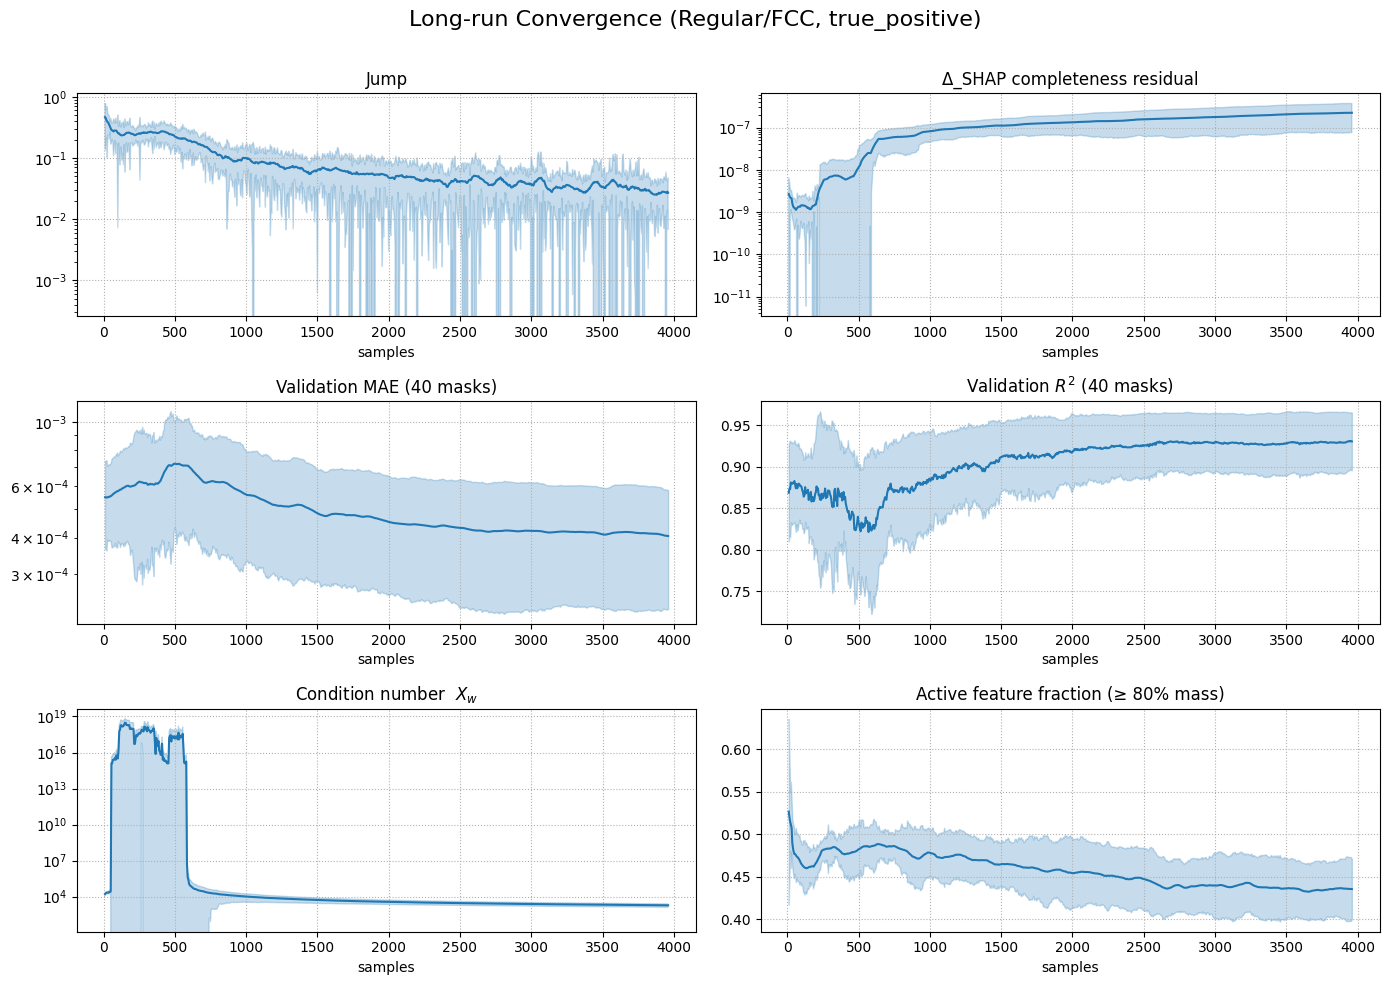

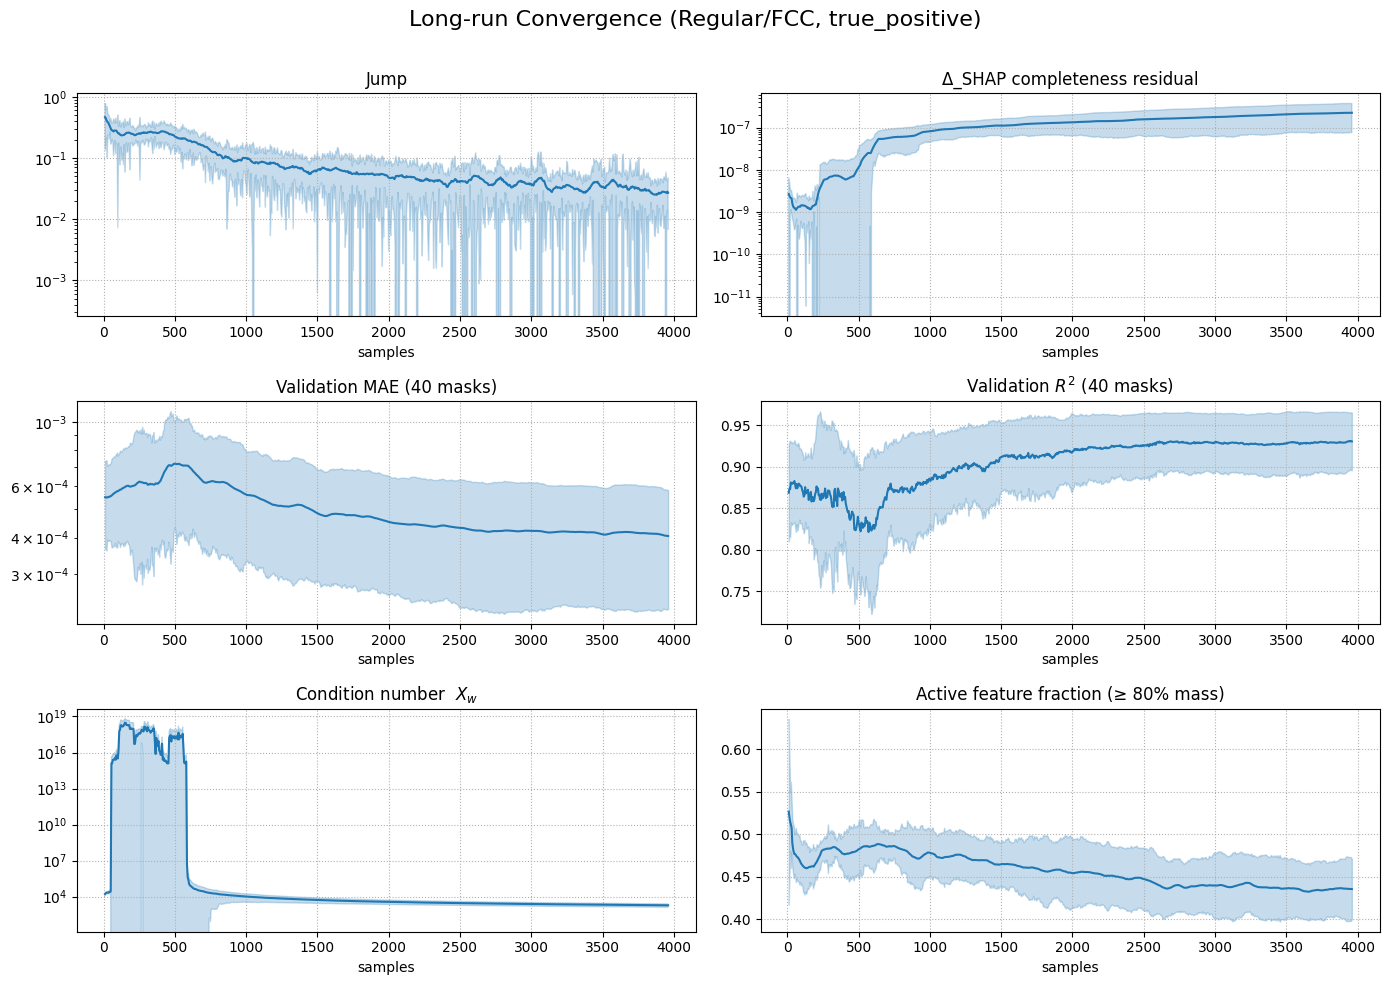

In [1]:
# ---------------------------------- Long-run single (Regular/FCC) true_positive aggregation (no subdir) ------------------------------
# This keeps the original utilities intact. We add a variant that reads from ../output/FCC/{pid}/dataset.pkl
# (i.e. without the aggregation subfolder) for a longer run (4000 samples) produced previously.

from pathlib import Path
import numpy as np, torch, pickle, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from my_load import CPU_Unpickler

LONG_RUN_SUPERVOXEL = "FCC"               # Regular
LONG_RUN_AGG = "true_positive_aggregation" # Logical aggregation label for saving/plot labeling
LONG_RUN_DATASET_LEN = 4000                # Extended number of samples
LONG_RUN_ROOT = Path("../output/FCC")     # Folder structure: ../output/FCC/{pid}/dataset.pkl
LONG_RUN_METRICS_FILE = Path("metrics_data") / "metrics_FCC_true_positive_longrun.pkl"

# Reuse patient IDs from the earlier computation (kept identical for comparability)
LONG_RUN_PATIENT_IDS = ["00004", "00005", "00024", "00027", "00029", "00034", "00039", "00044"]


def compute_metrics_long_run(
    root_dir: Path = LONG_RUN_ROOT,
    patient_ids = LONG_RUN_PATIENT_IDS,
    dataset_length: int = LONG_RUN_DATASET_LEN,
    step_size: int = 5,
    val_rows: int = 40,
    frac_target: float = 0.8,
    save_path: Path = LONG_RUN_METRICS_FILE,
    overwrite: bool = False,
):
    """Compute long-run convergence metrics for the Regular (FCC) supervoxel type.
    Differences vs original compute_metrics:
      * Root path does NOT include aggregation subfolder
      * Uses an extended dataset length (4000)
      * Saves to a distinct metrics file to avoid collisions
    """
    if save_path.exists() and not overwrite:
        print(f"[long-run] Metrics already exist at {save_path} (use overwrite=True to recompute)")
        return

    rng = np.random.default_rng(0)
    checkpoints = np.arange(step_size, dataset_length + 1 - val_rows, step_size)

    conv_L1, delta, val_mae, val_r2, nz_feat, cond_num = ([] for _ in range(6))

    def active_fraction(abs_coefs: np.ndarray, frac: float = 0.95) -> float:
        total = abs_coefs.sum()
        if total == 0:
            return 0.0
        sorted_abs = np.sort(abs_coefs)[::-1]
        cum = np.cumsum(sorted_abs)
        active_features = int((cum < frac * total).sum() + 1)
        return active_features / len(abs_coefs)

    def calculate_r2(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        ss_res = float(((y_true - y_pred) ** 2).sum())
        ss_tot = float(((y_true - y_true.mean()) ** 2).sum())
        return 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0

    def calculate_jump(beta: torch.Tensor, beta_prev: torch.Tensor, ord: int) -> float:
        eps = 1e-10
        difference = float(torch.norm(beta - beta_prev, p=ord))
        normalization = float(torch.norm(beta_prev, p=ord))
        return difference / (normalization + eps)

    for pid in patient_ids:
        pkl_path = root_dir / pid / "dataset.pkl"
        if not pkl_path.exists():
            print(f"[long-run][WARN] Missing dataset: {pkl_path}")
            continue
        with open(pkl_path, "rb") as f:
            ds = CPU_Unpickler(f).load()
        if hasattr(ds, 'tensors'):
            X, y, w = (t.cpu() for t in ds.tensors)
        else:
            raise ValueError("Loaded dataset object format unexpected (no tensors attribute)")

        f_x = y[0].item()
        idx_all = np.arange(X.shape[0])
        idx_choose_validation = idx_all[2:]
        val_idx = rng.choice(idx_choose_validation, size=val_rows, replace=False)
        train_idx = np.setdiff1d(idx_all, val_idx, assume_unique=True)
        X_val, y_val = X[val_idx].numpy(), y[val_idx].numpy()

        beta_prev = None
        cv, dl, mae, r2, cn = [], [], [], [], []
        coefs_list = []

        for n in checkpoints:
            n_train = min(n, len(train_idx))
            idx_sub = train_idx[:n_train]
            X_b, y_b, w_b = X[idx_sub].numpy(), y[idx_sub].numpy(), w[idx_sub].numpy()
            reg = LinearRegression()
            reg.fit(X_b, y_b, sample_weight=w_b)
            beta = torch.as_tensor(np.concatenate([[reg.intercept_], reg.coef_]), dtype=torch.float32)
            coefs_list.append(reg.coef_)
            if beta_prev is not None:
                cv.append(calculate_jump(beta, beta_prev, ord=1))
            beta_prev = beta.clone()
            dl.append(abs(f_x - beta.sum().item()))
            y_pred_val = reg.intercept_ + X_val @ reg.coef_
            mae.append(float(np.abs(y_val - y_pred_val).mean()))
            r2_val = calculate_r2(y_val, y_pred_val)
            r2.append(r2_val)
            Wsqrt = np.sqrt(w_b).reshape(-1, 1)
            Xw = np.column_stack([np.ones(n_train), X_b]) * Wsqrt
            try:
                _, svals, _ = np.linalg.svd(Xw, full_matrices=False)
                cn.append(svals[0] / svals[-1])
            except np.linalg.LinAlgError:
                cn.append(np.inf)

        nnz = [active_fraction(np.abs(c), frac_target) for c in coefs_list]
        conv_L1.append(cv); delta.append(dl); val_mae.append(mae); val_r2.append(r2); nz_feat.append(nnz); cond_num.append(cn)

    to_stats = lambda lst: (np.mean(lst, axis=0), np.std(lst, axis=0)) if len(lst) else (np.array([]), np.array([]))
    conv_m, conv_s = to_stats(conv_L1)
    delta_m, delta_s = to_stats(delta)
    mae_m, mae_s = to_stats(val_mae)
    r2_m, r2_s = to_stats(val_r2)
    nz_m, nz_s = to_stats(nz_feat)
    cond_m, cond_s = to_stats(cond_num)

    # Slightly stronger smoothing for the longer trajectory
    def smooth(arr: np.ndarray, win: int = 11) -> np.ndarray:
        if arr.size == 0:
            return arr
        pad = win // 2
        out = np.empty_like(arr)
        for i in range(len(arr)):
            lo, hi = max(0, i - pad), min(len(arr), i + pad + 1)
            out[i] = arr[lo:hi].mean()
        return out

    for arr in (conv_m, delta_m, mae_m, nz_m):
        arr[:] = smooth(arr)

    x_conv = checkpoints[1:]  # conv-related series start after first jump

    metrics = dict(
        x_conv=x_conv,
        conv_m=conv_m, conv_s=conv_s,
        delta_m=delta_m, delta_s=delta_s,
        mae_m=mae_m, mae_s=mae_s,
        r2_m=r2_m, r2_s=r2_s,
        nz_m=nz_m, nz_s=nz_s,
        cond_m=cond_m, cond_s=cond_s,
        VAL_ROWS=val_rows,
        FRAC_TARGET=frac_target,
        DATASET_LENGTH=dataset_length,
        STEP_SIZE=step_size,
        SUPERVOXEL=LONG_RUN_SUPERVOXEL,
        AGGREGATION=LONG_RUN_AGG,
        ROOT=str(root_dir.resolve())
    )

    LONG_RUN_METRICS_FILE.parent.mkdir(exist_ok=True)
    with open(save_path, 'wb') as f:
        pickle.dump(metrics, f)
    print(f"[long-run] Computed & saved → {save_path}")


def load_metrics_long_run(path: Path = LONG_RUN_METRICS_FILE):
    if not path.exists():
        print(f"[long-run] Missing metrics file: {path}")
        return None
    with open(path, 'rb') as f:
        return pickle.load(f)


def plot_long_run(metrics_path: Path = LONG_RUN_METRICS_FILE, save_fig: bool = True):
    m = load_metrics_long_run(metrics_path)
    if m is None:
        return
    x = m['x_conv']
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    axes = axes.ravel()

    def shaded(ax, x, y, s, title, log=False):
        if y.size == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            return
        ax.plot(x, y, color='tab:blue')
        if s.size and s.shape == y.shape:
            ax.fill_between(x, y - s, y + s, color='tab:blue', alpha=0.25)
        ax.set_title(title)
        if log:
            ax.set_yscale('log')
        ax.grid(ls=':')

    shaded(axes[0], x, m['conv_m'], m['conv_s'], 'Jump', log=True)
    shaded(axes[1], x, m['delta_m'][1:], m['delta_s'][1:], 'Δ_SHAP completeness residual', log=True)
    shaded(axes[2], x, m['mae_m'][1:], m['mae_s'][1:], f'Validation MAE ({m["VAL_ROWS"]} masks)', log=True)
    shaded(axes[3], x, m['r2_m'][1:], m['r2_s'][1:], f'Validation $R^2$ ({m["VAL_ROWS"]} masks)')
    shaded(axes[4], x, m['cond_m'][1:], m['cond_s'][1:], 'Condition number  $X_w$', log=True)
    shaded(axes[5], x, m['nz_m'][1:], m['nz_s'][1:], f'Active feature fraction (≥ {m["FRAC_TARGET"]*100:.0f}% mass)')

    for ax in axes:
        ax.set_xlabel('samples')

    fig.suptitle('Long-run Convergence (Regular/FCC, true_positive)', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    if save_fig:
        out_dir = Path('dashboards')
        out_dir.mkdir(exist_ok=True)
        out_file = out_dir / 'convergence_longrun_FCC_true_positive.png'
        fig.savefig(out_file, dpi=300, bbox_inches='tight')
        print(f"[long-run] Saved figure → {out_file}")
    return fig

# --- Execute (idempotent) ---
compute_metrics_long_run(overwrite=False)  # Set overwrite=True to force recompute
plot_long_run()

[long-run] Saved colored figure → dashboards/convergence_longrun_FCC_true_positive_colored.png


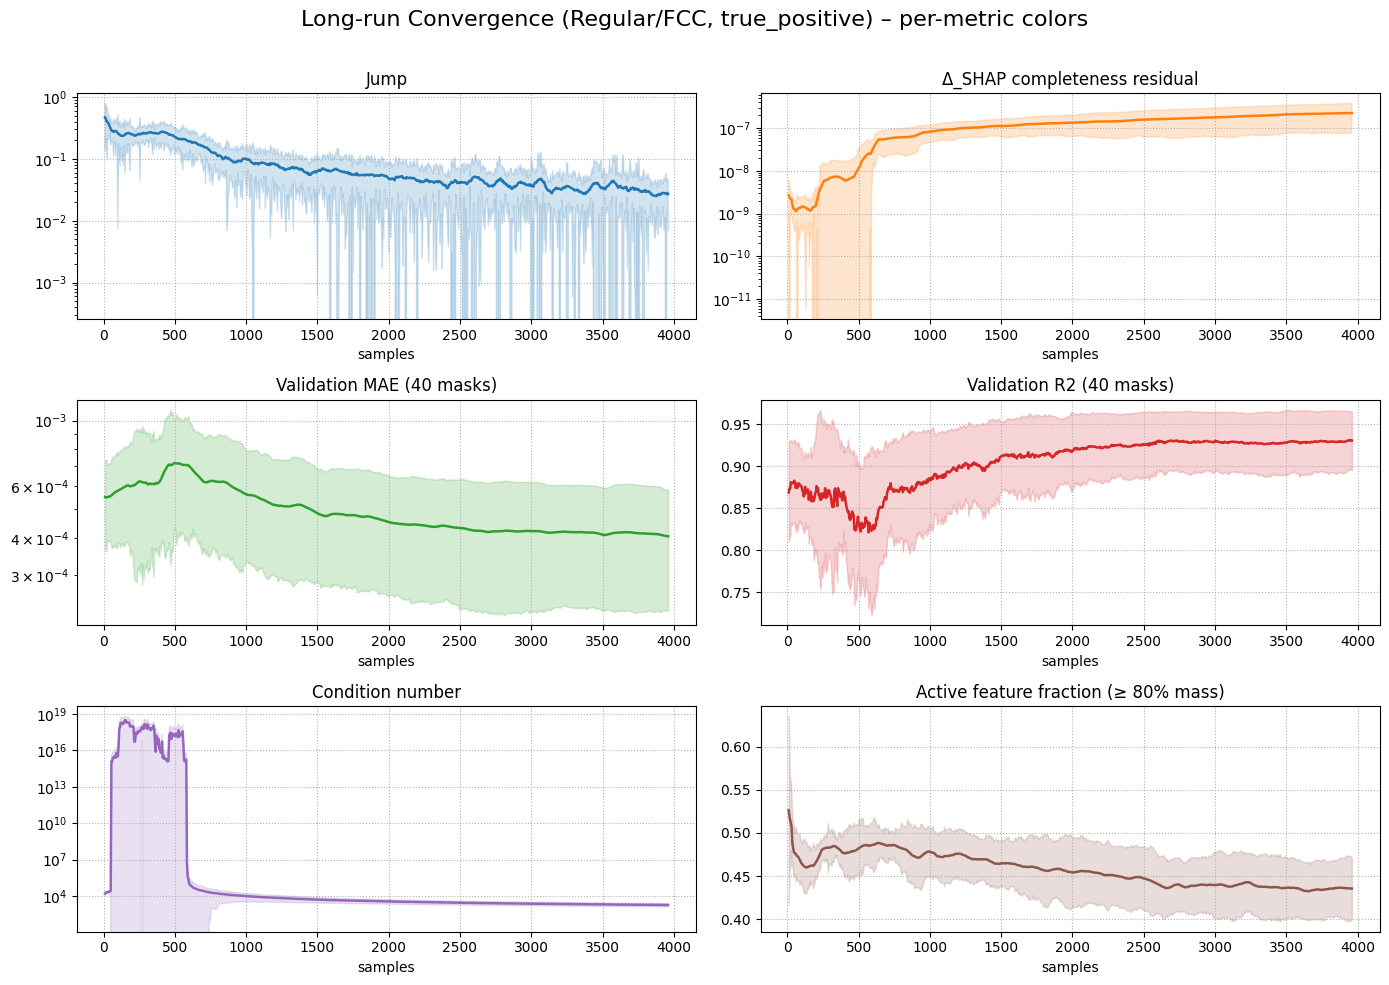

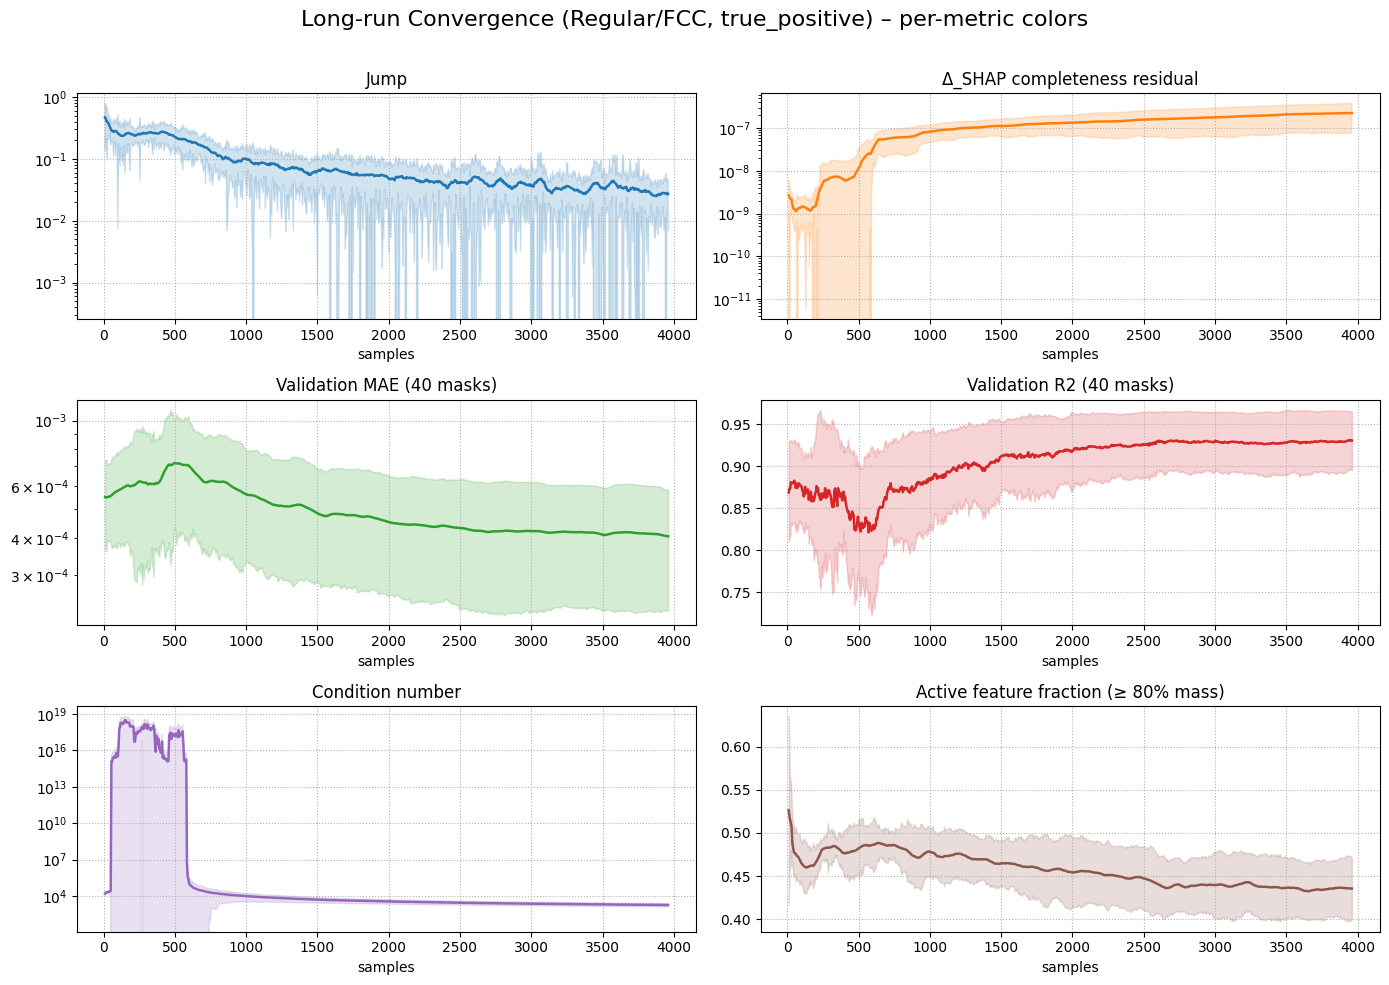

In [2]:
# ---------------- Long-run (Regular/FCC) re-plot with per-metric colors (no recomputation) ----------------
# Uses the already saved metrics file and assigns a distinct color to each metric
# to visually differentiate their trajectories.

import matplotlib.pyplot as plt
from pathlib import Path

# Reuse LONG_RUN_METRICS_FILE & load_metrics_long_run defined above

METRIC_COLOR_MAP = {
    'Jump': 'tab:blue',
    'Δ_SHAP completeness residual': 'tab:orange',
    'Validation MAE': 'tab:green',
    'Validation R2': 'tab:red',
    'Condition number': 'tab:purple',
    'Active feature fraction': 'tab:brown'
}

def plot_long_run_colored(metrics_path: Path = LONG_RUN_METRICS_FILE, save_fig: bool = True):
    m = load_metrics_long_run(metrics_path)
    if m is None:
        return
    x = m['x_conv']

    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    axes = axes.ravel()

    entries = [
        ('Jump',                m['conv_m'], m['conv_s'], True),
        ('Δ_SHAP completeness residual', m['delta_m'][1:], m['delta_s'][1:], True),
        (f'Validation MAE ({m["VAL_ROWS"]} masks)', m['mae_m'][1:], m['mae_s'][1:], True),
        (f'Validation R2 ({m["VAL_ROWS"]} masks)',  m['r2_m'][1:],  m['r2_s'][1:], False),
        ('Condition number',    m['cond_m'][1:], m['cond_s'][1:], True),
        (f'Active feature fraction (≥ {m["FRAC_TARGET"]*100:.0f}% mass)', m['nz_m'][1:], m['nz_s'][1:], False)
    ]

    for ax, (title, y, s, logy) in zip(axes, entries):
        base_title_key = title.split(' (')[0]  # strip dynamic parts for color map when needed
        color_key = base_title_key if base_title_key in METRIC_COLOR_MAP else title
        color = METRIC_COLOR_MAP.get(color_key, 'black')
        if y.size == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            continue
        # For delta/jump we already aligned x to x_conv; for others we also use x (skip first element already removed)
        ax.plot(x, y, color=color, lw=1.8)
        if s.size and s.shape == y.shape:
            ax.fill_between(x, y - s, y + s, color=color, alpha=0.20)
        ax.set_title(title)
        if logy:
            ax.set_yscale('log')
        ax.grid(ls=':')
        ax.set_xlabel('samples')

    fig.suptitle('Long-run Convergence (Regular/FCC, true_positive) – per-metric colors', fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])

    if save_fig:
        out_dir = Path('dashboards')
        out_dir.mkdir(exist_ok=True)
        out_file = out_dir / 'convergence_longrun_FCC_true_positive_colored.png'
        fig.savefig(out_file, dpi=300, bbox_inches='tight')
        print(f"[long-run] Saved colored figure → {out_file}")
    return fig

# Run only plotting (no recomputation)
plot_long_run_colored()